In [418]:
import autoencodeSVJ.utils as utils
import autoencodeSVJ.models as models
import autoencodeSVJ.trainer as trainer
import glob
import os
import numpy as np

### 1: load and normalize input data
we can use the data_loader for this. 
add an h5 sample, grab the table which represents it, and then split the table into training and testing datasets:

In [487]:
# get h5 datasets
data,jet_tables = utils.get_training_data_jets("../../data/dijet_tight/*data.h5")
data.head()

data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/0.0_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/7_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/8_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/6_data.h5'
data_loader :: Grabbing dataset with keys [u'event_feature_data']
data_loader :: Adding sample at path '/afs/cern.ch/work/l/llepotti/private/CMS/CMSSW_8_0_20/src/autoencodeSVJ/data/dijet_tight/5_data.h5'
data_loader :: Grabbing dataset with keys [u

,jetEta,jetPhi,jetPt,jetM,jetChargedFraction,jetPTD,jetAxis2
0,0.391208,3.126895,880.629578,46.972202,0.941176,0.238104,0.041430
1,0.226281,1.619783,839.069214,27.909035,0.631579,0.254852,0.016366
2,1.215448,0.042642,1736.550293,164.827713,0.608696,0.418112,0.006629
3,-0.121109,-1.891376,453.773132,62.488964,0.771429,0.162267,0.079624
4,1.025759,3.117460,882.341492,160.383484,0.600000,0.215028,0.021459


#### plotting
we'll also plot the input histograms here, to make sure there are no screaming discrepancies in the training and testing sets

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'train', 'test']


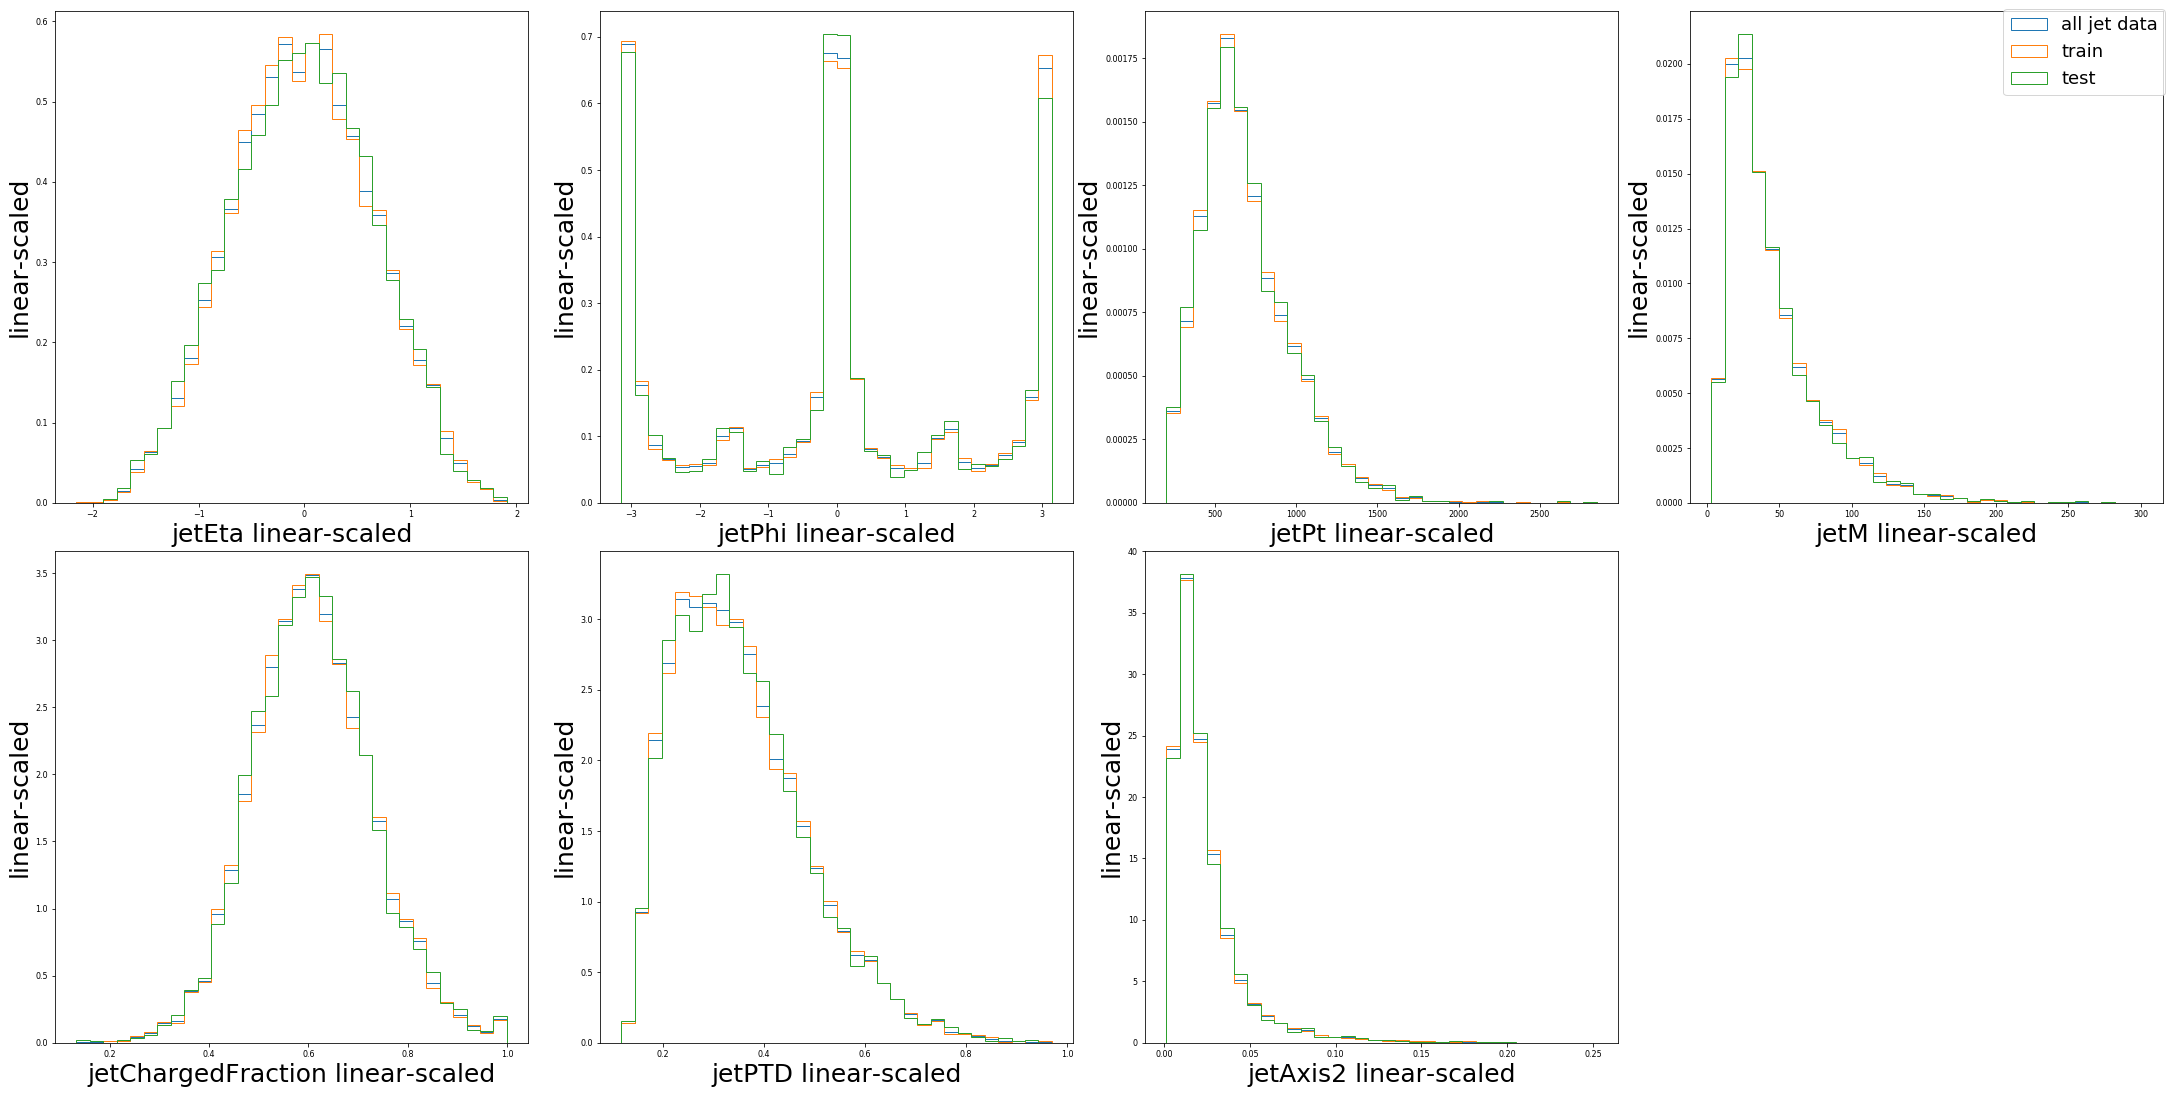

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'jet 0', 'jet 1']


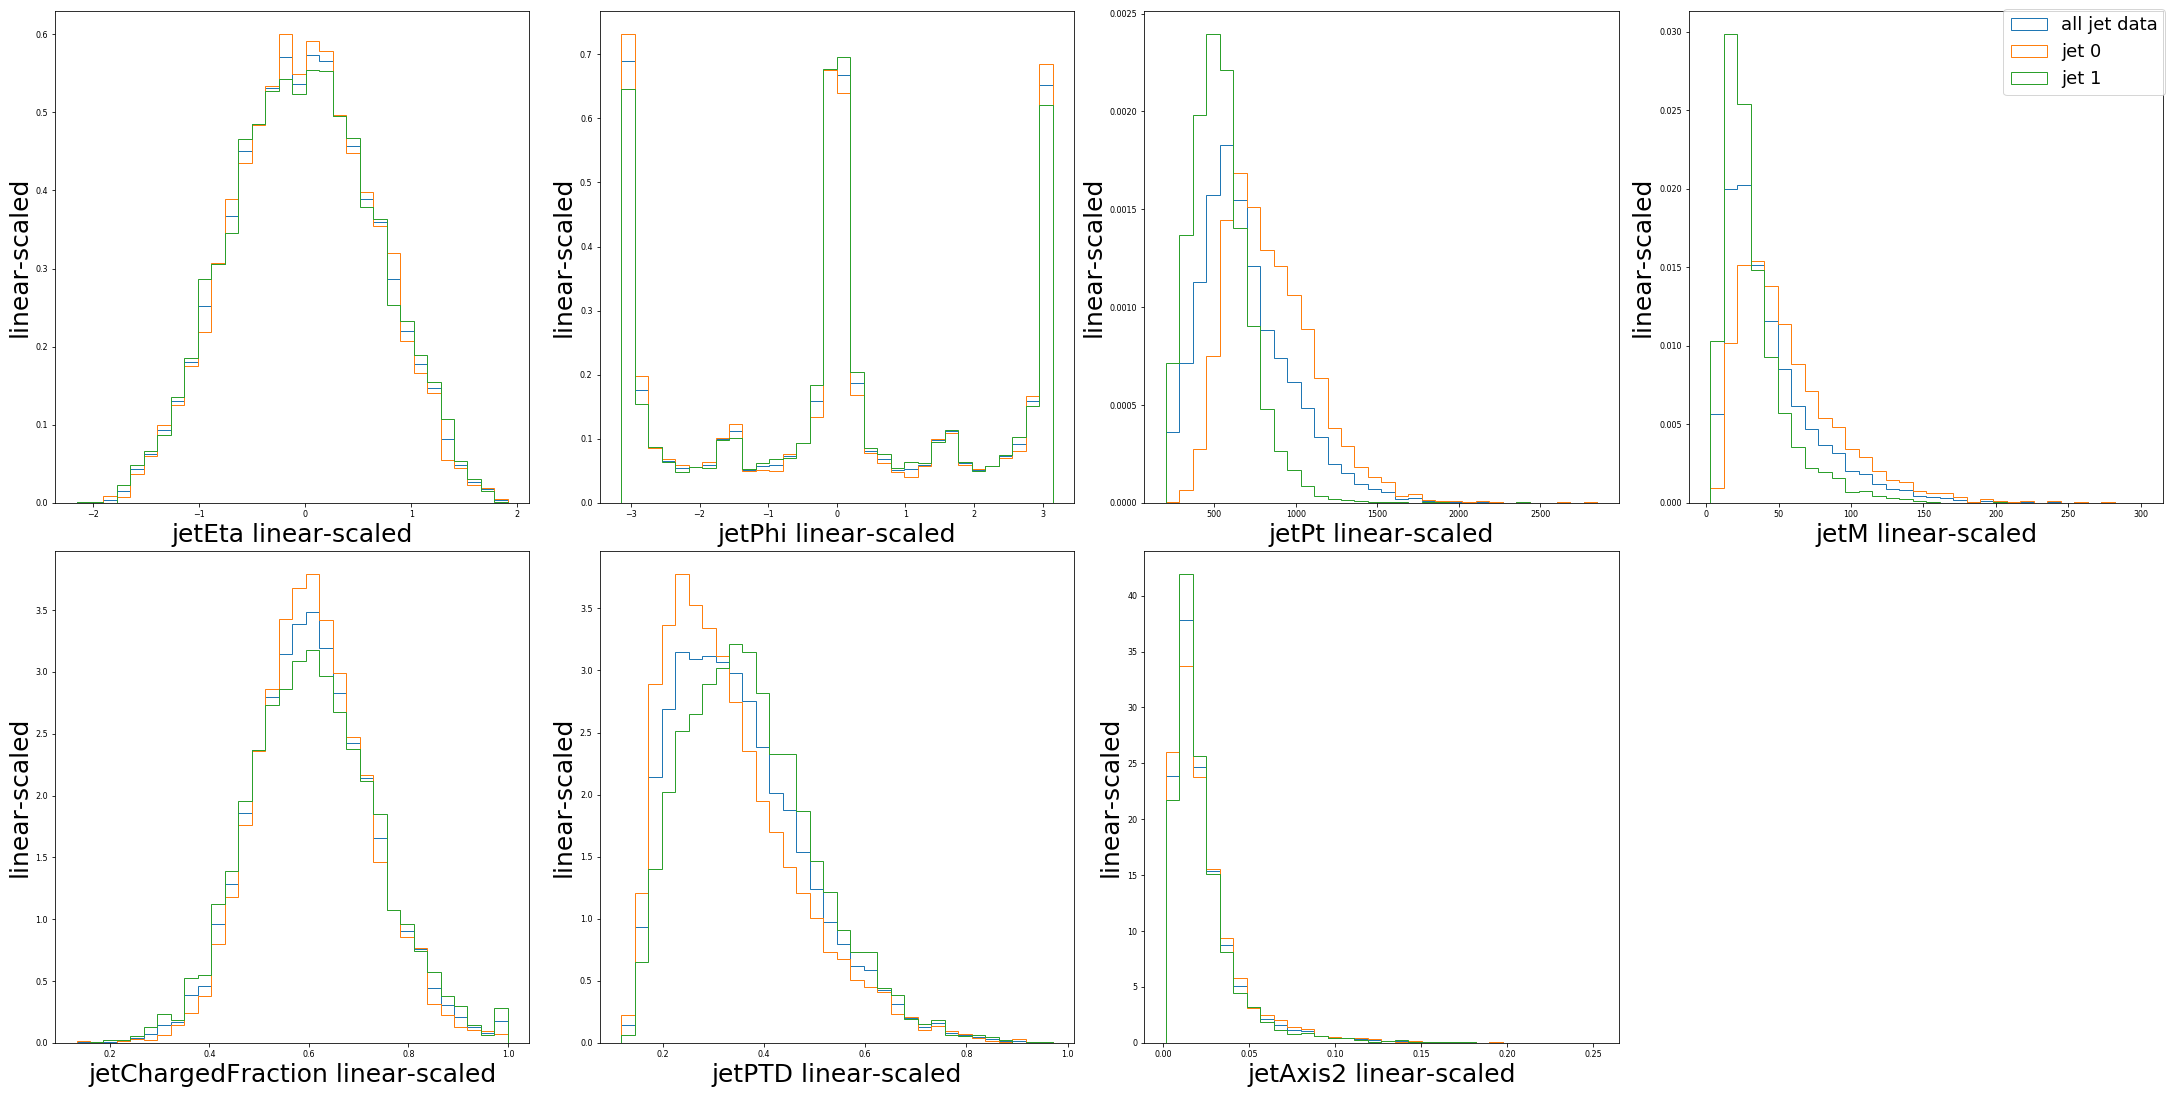

In [488]:
train, test = data.train_test_split(0.3)
data.plot([train, test], normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)
data.plot(jet_tables, normed=1, bins=32, figsize=(30,15), fontsize=25, cols=4, alpha=1)

We then get training/testing datasets, and normalize them to the main data set. We can check how the normalized features look compared with one another, to make sure that they are useful. This way we can decide what type of normalization to use.

data_table :: plotting distrubution(s) for table(s) ['jetEta', 'jetPhi', 'jetPt', 'jetM', 'jetChargedFraction', 'jetPTD', 'jetAxis2']


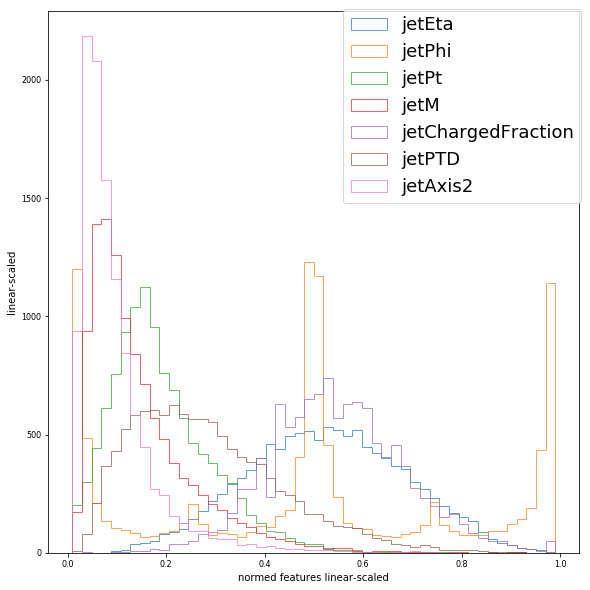

In [714]:
norm_args = {
    "norm_type": "MinMaxScaler",
    "feature_range": (0.01, 0.99)
}

norm_data = data.norm(**norm_args)
features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

train_norm, test_norm = data.norm(train, **norm_args), data.norm(test, **norm_args)


# rmin, rmax = np.asarray([(data.median() - 2.*data.std()).values, (data.median() + 2.*data.std()).values])
# custom_norm = lambda x: (x - rmin) / (rmax - rmin)
# # norm_data = data.norm(norm_type=0, rng=rng)
# norm_data = custom_norm(data)
# features = [utils.data_table(norm_data[c].values.reshape(norm_data[c].shape[0],1), name=c, headers=["normed features"]) for c in norm_data]
# features[0].plot(features[1:], bins=50, figsize=(8,8), fontsize=10)

### 2. build model 
To make our model, we'll use the simple "shallow" architecture defined in models.py. This gives us a decidedly shallow autoencoder with a bottleneck of our liking.

In [777]:
def log_K_lognormal(x, a1, a2, a3):
    return 0.5*((K.log(x) - a1)/a2)**2. - K.log(a3/(a2*x*np.sqrt(2.0*np.pi)))

def log_K_gaussian(x, a1, a2):
    return 0.5*((x - a1)/a2)**2. - K.log(1.0/(2.*a2*np.sqrt(2.0*np.pi)))

def log_K_phi_pdf(x, frac, sig1, sig2):
    return -K.log(K_phi_pdf(x, frac, sig1, sig2))
 
def K_lognormal(x,a1,a2,a3):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    mask = K.cast(K.greater(x, 0.), 'float32')
    return mask*a3/(x*a2*K.sqrt(K.variable(2.*np.pi)))*K.exp(-(K.log(x) - a1)**2./(2.*a2*a2)) + (1. - mask)*10e-5
      
def K_gaussian(x, a1, a2):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return (1./(a2*np.sqrt(2.*np.pi)))*K.exp((-(x - a1)*(x - a1))/(2.*a2*a2))

def K_phi_pdf(x, frac, sig1, sig2):
#     ret = K.cast(K.greater(sig1, 0), 'float32')*K.cast(K.greater(sig2, 0), 'float32')
    ratio = K_gaussian(0, 0, sig1)/K_gaussian(0, 0, sig2)
    f1 = frac/ratio
    f2 = frac*ratio
    ret = f1*K_gaussian(x, 0.01, sig1) + f2*K_gaussian(x, .255, sig2) + f1*K_gaussian(x, .5, sig1) + f2*K_gaussian(x, .745, sig2) + f1*K_gaussian(x, .99, sig1)
    mask = K.cast(K.greater(ret, 0.), "float32")
    return ret*mask + (1. - mask)*10e-8

def K_custom_loss(true, pred):
    mus, sigmas, skews, others = pred[:,0:6], pred[:,6:14], pred[:,14:18], pred[:,18:19]
    loss = (
        log_K_gaussian(
            true[:,0],
            mus[:,0], sigmas[:,0]
        )
    )
    loss = loss + (
        log_K_phi_pdf(
            true[:,1],
            others[:,0], sigmas[:,1], sigmas[:,2]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,2],
            mus[:,1], sigmas[:,3], skews[:,0],
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,3],
            mus[:,2], sigmas[:,4], skews[:,1]
        )
    )
    loss = loss + (
        log_K_gaussian(
            true[:,4],
            mus[:,3], sigmas[:,5]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,5],
            mus[:,4], sigmas[:,6], skews[:,2]
        )
    )
    loss = loss + (
        log_K_lognormal(
            true[:,6],
            mus[:,5], sigmas[:,7], skews[:,3]
        )
    )
    return K.mean(loss)

In [778]:
def min_layer(inputs, size, name, activation="linear", min_value=10e-6, offset=0):
    set_to = min_value + offset
    ret = keras.layers.Dense(size, activation="linear")(inputs)
    def lambda_func(s, m):
        def subfunc(x):
            mask = K.cast(K.greater(x, m), 'float32')
            return x*mask + (1. - mask)*s
        return subfunc
    
    return keras.layers.Lambda(
        lambda_func(set_to, min_value), output_shape=(size,), name=name
    )(ret)
    

inputs = keras.layers.Input(shape=(7,), name="input")
encoded = keras.layers.Dense(30, activation="relu", name="dense_encode")(inputs)
encoded = keras.layers.Dense(5, activation="relu", name="encoded")(encoded)
encoder = keras.Model(inputs=inputs, outputs=encoded, name="encoder")

decoder_inputs = keras.layers.Input(shape=(5,), name="decoder_inputs")
decoded = keras.layers.Dense(30, activation="relu", name="dense_decode")(decoder_inputs)
# decoded = keras.layers.Dense(20, activation="linear")(decoded)
mus = keras.layers.Dense(6, activation="linear", name="mus")(decoded)
sigmas = min_layer(decoded, 8, "sigmas")
skews = min_layer(decoded, 4, "skews")
others = min_layer(decoded, 1, "others")
decoded = keras.layers.concatenate([mus, sigmas, skews, others], axis=-1)


decoder = keras.Model(inputs=decoder_inputs, outputs=decoded, name="decoder")

autoencoder = keras.Model(inputs=inputs, outputs=decoder(encoder(inputs)), name="autoencoder")
autoencoder.compile(optimizer="adam", loss=K_custom_loss)

In [780]:
name = "custom_5"
instance = trainer.trainer(os.path.join("../data/training_runs/7jf/custom", name))

h5_elt 'metric_names' :: creating group 'data' in file 'custom_5.h5'
h5_elt 'metric_names' :: creating dataset 'data/metric_names' in file 'custom_5.h5'
h5_elt 'training' :: creating group 'params' in file 'custom_5.h5'
h5_elt 'training' :: creating dataset 'params/training' in file 'custom_5.h5'
h5_elt 'config' :: creating dataset 'params/config' in file 'custom_5.h5'


... and the model summaries:

In [781]:
print('encoder summary:')
encoder.summary()
print('\n')
print('decoder summary:')
decoder.summary()
print('\n')
print('autoencoder summary:')
autoencoder.summary()


encoder summary:
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 7)                 0         
_________________________________________________________________
dense_encode (Dense)         (None, 30)                240       
_________________________________________________________________
encoded (Dense)              (None, 5)                 155       
Total params: 395
Trainable params: 395
Non-trainable params: 0
_________________________________________________________________


decoder summary:
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoder_inputs (InputLayer)     (None, 5)            0                                            
___________________________________________________________________________

### 3. train model 
this can be most easily done using the `training_skeleton`, defined in `skeletons.py`. This helps with dynamic training and allows for stopping midway without losing history information, retraining models, etc.

In [782]:
# name = "medium_4_test"
# instance = trainer.trainer(os.path.join("../data/training_runs/7jf/mean_std_norm/", name))

training is easy:

In [794]:
from keras import backend as K

def r_square(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return ( 1 - SS_res/(SS_tot + K.epsilon()))

def r_square_loss(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return SS_res/(SS_tot + K.epsilon())

# train, test = data.train_test_split(0.25)
# ntype="RobustScaler"
# train_norm, test_norm = data.norm(train, norm_type=ntype), data.norm(test, norm_type=ntype)

train_pad = np.pad(train_norm.data, ((0,0),(0,19 - train_norm.data.shape[1])), 'constant')
test_pad = np.pad(test_norm.data, ((0,0),(0,19 - test_norm.data.shape[1])), 'constant')

autoencoder = instance.train(
    x_train=train_norm.data,
    x_test=test_norm.data,
    y_train=train_pad,
    y_test=test_pad,
#     y_train=np.ones((train_norm.shape[0], 20)),
#     y_test=np.ones((test_norm.shape[0], 20)),
    optimizer="adam",
    loss=K_custom_loss,
    epochs=5,
    model=autoencoder,
    metrics=[],
    force=True,
    batch_size=32,
    use_callbacks=False,
    learning_rate=0.005,
)

train_shell :: using model passed as function argument
train_shell :: TRAINING EPOCH 35/40
Train on 7865 samples, validate on 3371 samples
Epoch 36/36
245/245 [==============================] - 15s 60ms/step - loss: 84253.8821 - val_loss: -32.9307
train_shell :: TRAINING EPOCH 36/40
Train on 7865 samples, validate on 3371 samples
Epoch 37/37
245/245 [==============================] - 5s 22ms/step - loss: -36.9033 - val_loss: -38.9074
train_shell :: TRAINING EPOCH 37/40
Train on 7865 samples, validate on 3371 samples
Epoch 38/38
245/245 [==============================] - 5s 22ms/step - loss: -39.6268 - val_loss: -40.5320
train_shell :: TRAINING EPOCH 38/40
Train on 7865 samples, validate on 3371 samples
Epoch 39/39
245/245 [==============================] - 5s 21ms/step - loss: -41.1387 - val_loss: -41.5027
train_shell :: TRAINING EPOCH 39/40
Train on 7865 samples, validate on 3371 samples
Epoch 40/40
245/245 [==============================] - 5s 21ms/step - loss: -41.7174 - val_loss: -

### 4. check results
it is easy to check things like loss, accuracy, etc. later on with this method - all data is saved to an h5 file unique to that training name.

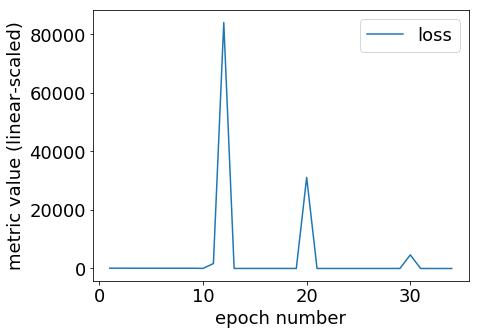

In [792]:
instance.plot_metrics(fnmatch_criteria="loss", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*absolute*", yscale="linear")
# instance.plot_metrics(fnmatch_criteria="*r_square*", yscale="linear")

checking results:

(11236, 7)


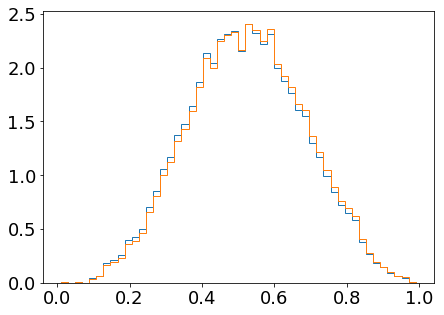

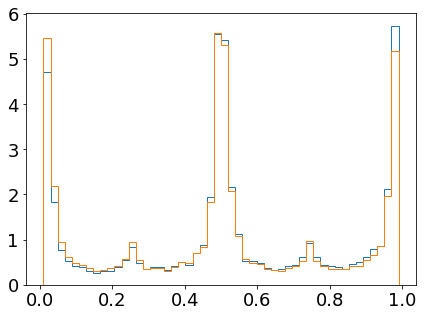

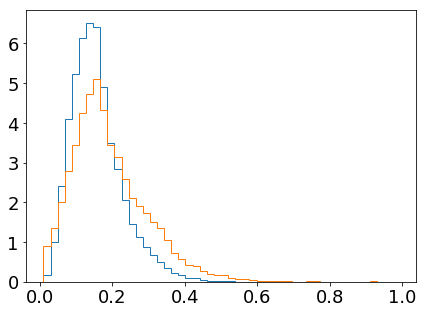

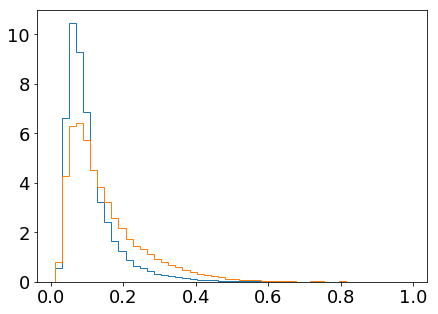

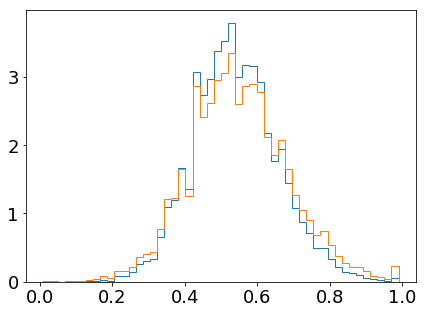

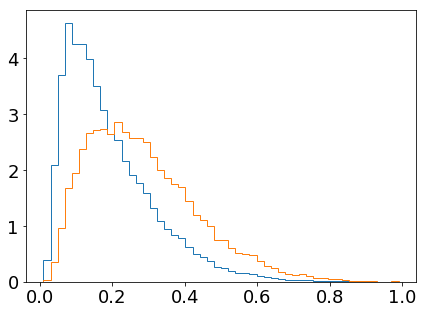

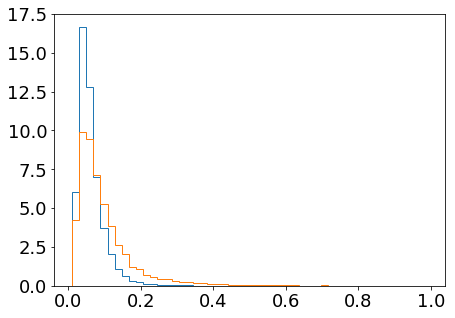

In [795]:
def np_lognormal(x,a1,a2,a3):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return a3/(x*a2*np.sqrt(2.*np.pi))*np.exp(-(np.log(x) - a1)**2./(2.*a2*a2))
      
def np_gaussian(x, a1, a2):
#     ret = K.cast(K.greater(a2, 0), 'float32')
    return (1./(a2*np.sqrt(2.*np.pi)))*np.exp((-(x - a1)*(x - a1))/(2.*a2*a2))

def np_phi_pdf(x, frac, sig1, sig2):
#     ret = K.cast(K.greater(sig1, 0), 'float32')*K.cast(K.greater(sig2, 0), 'float32')
    ratio = np_gaussian(0, 0, sig1)/np_gaussian(0, 0, sig2)
    f1 = frac/ratio
    f2 = frac*ratio
    ret = f1*np_gaussian(x, 0.01, sig1) + f2*np_gaussian(x, .255, sig2) + f1*np_gaussian(x, .5, sig1) + f2*np_gaussian(x, .745, sig2) + f1*np_gaussian(x, .99, sig1)
    mask = np.where(ret > 0.)[0].astype(float)
    return ret*mask + (1. - mask)*10e-8


def np_phi_gaussians(x, dist, frac, sig1, sig2):
    f1 = 1./frac
    f2 = frac
    return  np.asarray([f1*np_gaussian(x, 0, sig1), f2*np_gaussian(x, 1.*dist, sig2), f1*np_gaussian(x, 2.*dist, sig1), f2*np_gaussian(x, 3.*dist, sig2), f1*np_gaussian(x, 4.*dist, sig1)])

def get_probabilities(true, pred):
    ret = []
    mus, sigmas, skews, others = pred[:,0:6], pred[:,6:14], pred[:,14:18], pred[:,18:20]
    ret.append(np_gaussian(true[:,0], mus[:,0], sigmas[:,0]))
    ret.append(np_phi_pdf(true[:,1], others[:,0], sigmas[:,1], sigmas[:,2]))
    ret.append(np_lognormal(true[:,2], mus[:,1], sigmas[:,3], skews[:,0]))
    ret.append(np_lognormal(true[:,3], mus[:,2], sigmas[:,4], skews[:,1]))
    ret.append(np_gaussian(true[:,4], mus[:,3], sigmas[:,5]))
    ret.append(np_lognormal(true[:,5], mus[:,4], sigmas[:,6], skews[:,2]))
    ret.append(np_lognormal(true[:,6], mus[:,5], sigmas[:,7], skews[:,3]))
    return np.asarray(ret)

pred = autoencoder.predict(norm_data.data)

weights = get_probabilities(norm_data.data, pred).T

from sklearn.preprocessing import MinMaxScaler

# weights = MinMaxScaler().fit_transform(weights)

print weights.shape

for i,w in enumerate(weights.T):
#     plt.hist(w, bins=30, normed=1, histtype='step')

    plt.hist(norm_data.data[:,i], weights=w, bins=50, normed=1, histtype='step')
    plt.hist(norm_data.data[:,i], bins=50, normed=1, histtype='step')
    plt.show()


In [771]:
# x = np.arange(0,.5,0.002)
# pgs = np_phi_gaussians(x,.1, .2, 0.01, 0.005)
# plt.plot(x, pgs.sum(axis=0))
plt.show()

data_table :: plotting distrubution(s) for table(s) ['all jet data', 'all jet data (pred)']


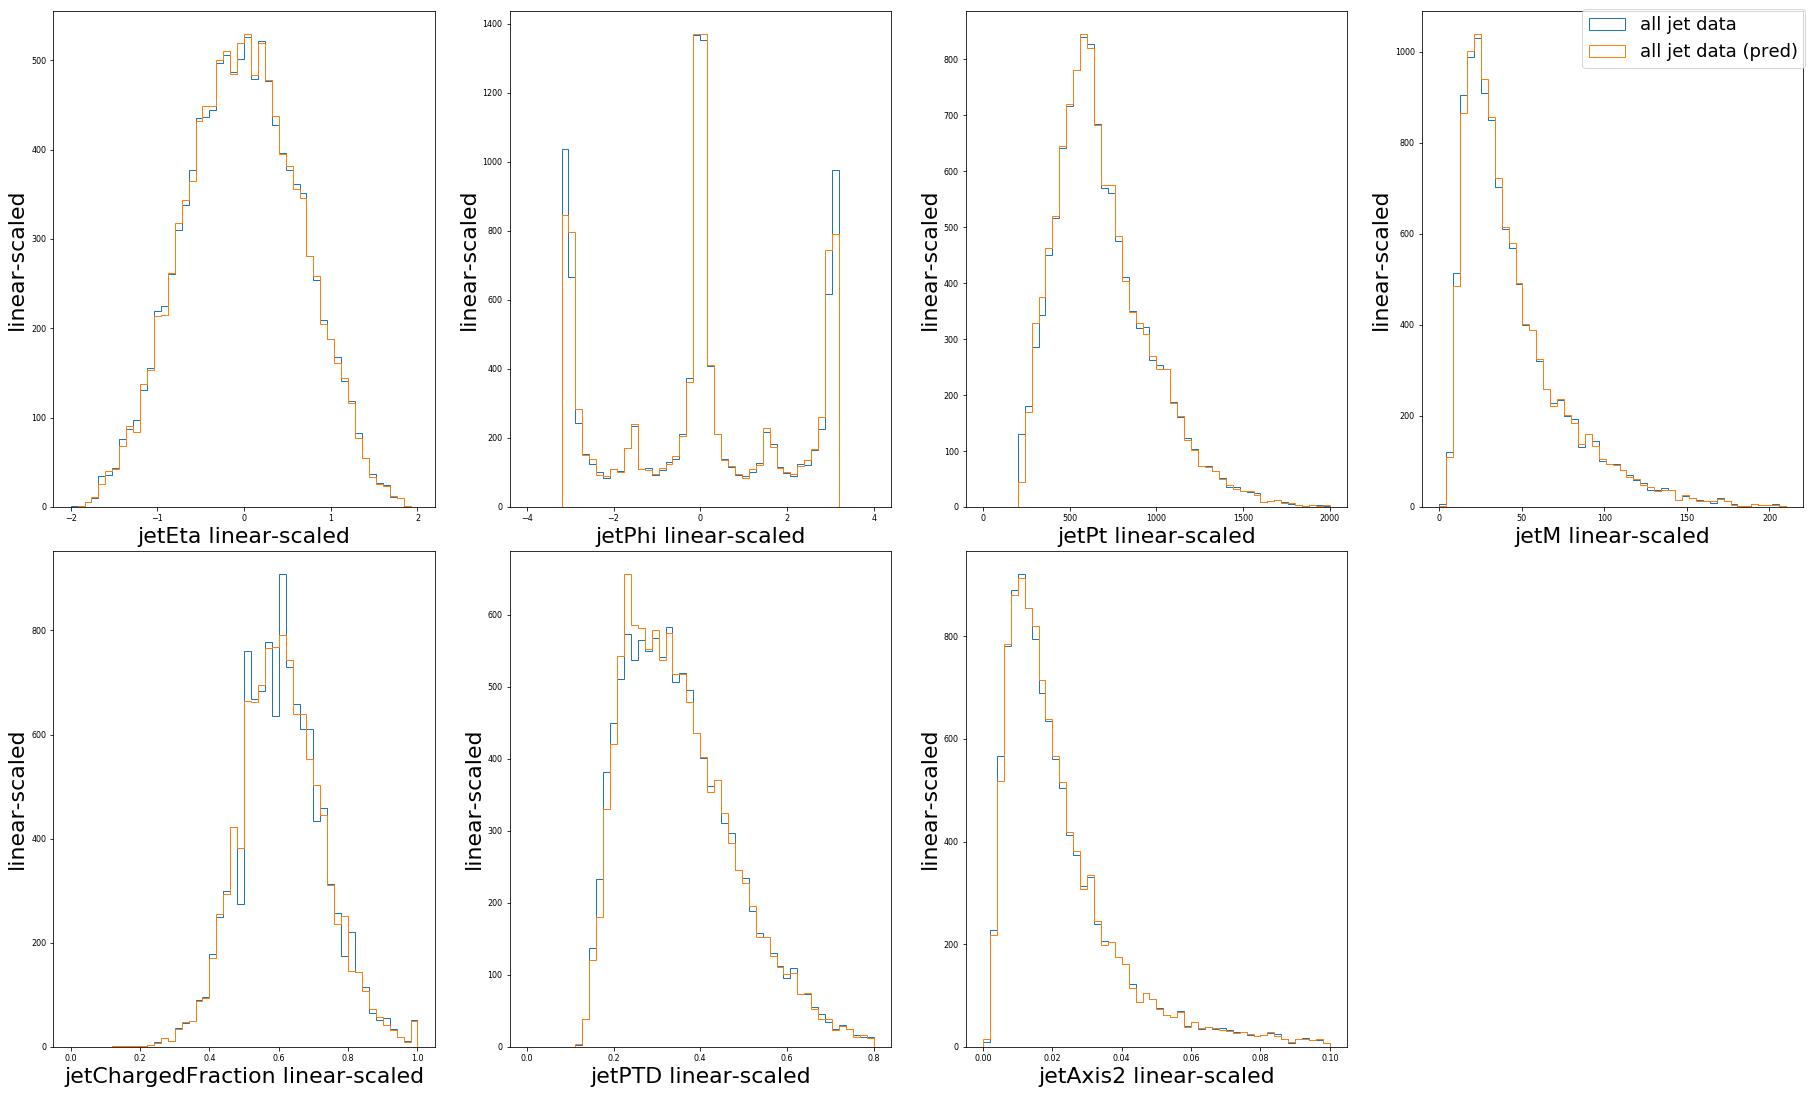

data_table :: plotting distrubution(s) for table(s) ["'all jet data' normed to 'all jet data'", 'untitled 462']


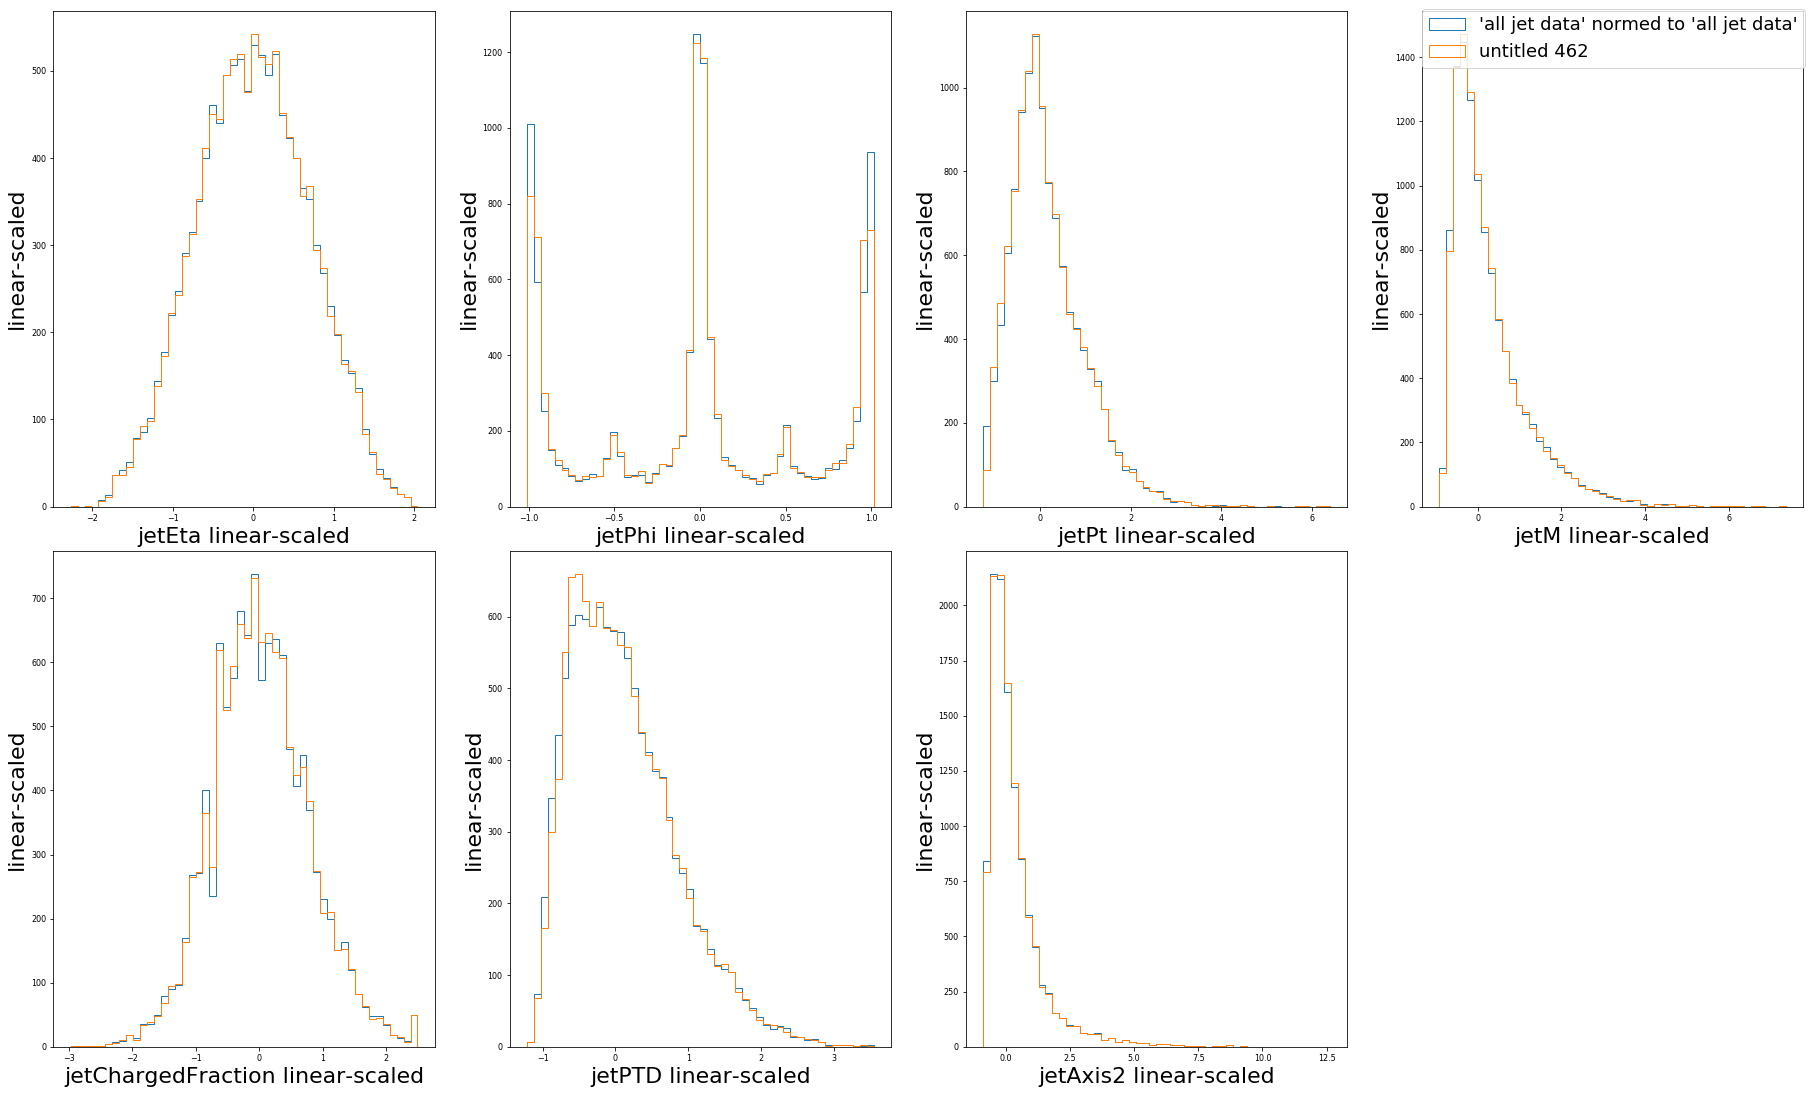

In [630]:

# data_recon_norm = utils.data_table(autoencoder.predict(data.norm(**norm_args).df.values), headers=train_norm.headers)
# data_recon = data.inorm(data_recon_norm, **norm_args)
# data_recon.name = "all jet data (pred)"

# # train_reconstructed_norm = data_table(autoencoder.predict(train_norm.data), headers=train_norm.headers)
# # test_reconstructed_norm = data_table(autoencoder.predict(test_norm.data), headers=test_norm.headers)

# # train_reconstructed = data.inorm(train_reconstructed_norm)
# # # test_reconstructed = data.inorm(test_reconstructed_norm)


# # train_reconstructed.name = "train reconstructed"
# # test_reconstructed.name = "test reconstructed"

# # train.plot([train_reconstructed], bins = 30, alpha=1.0)
# # test.plot([test_reconstructed], bins=30, alpha=1.0)
# data.plot(
# #     [train_reconstructed, test_reconstructed],
#     data_recon,
#     normed=0, bins=50, alpha=1.0, figloc="upper right",
#     figsize=(25,15), fontsize=22, rng=[(-2,2), (-4,4), (0,2000), (0,210), (0,1), (0,0.8), (0, .10)]
# )

# data.norm(**norm_args).plot(
#     data_recon_norm,
#     normed=0, bins=50, alpha=1.0, figloc="upper right",
#     figsize=(25,15), fontsize=22
# )

In [631]:
encoder, decoder = autoencoder.layers[1:]
train_reps, test_reps = (
    utils.data_table(encoder.predict(train_norm.data), name="train_reps"),
    utils.data_table(encoder.predict(test_norm.data), name="test_reps")
)

data_table :: plotting distrubution(s) for table(s) ['train_reps', 'test_reps']


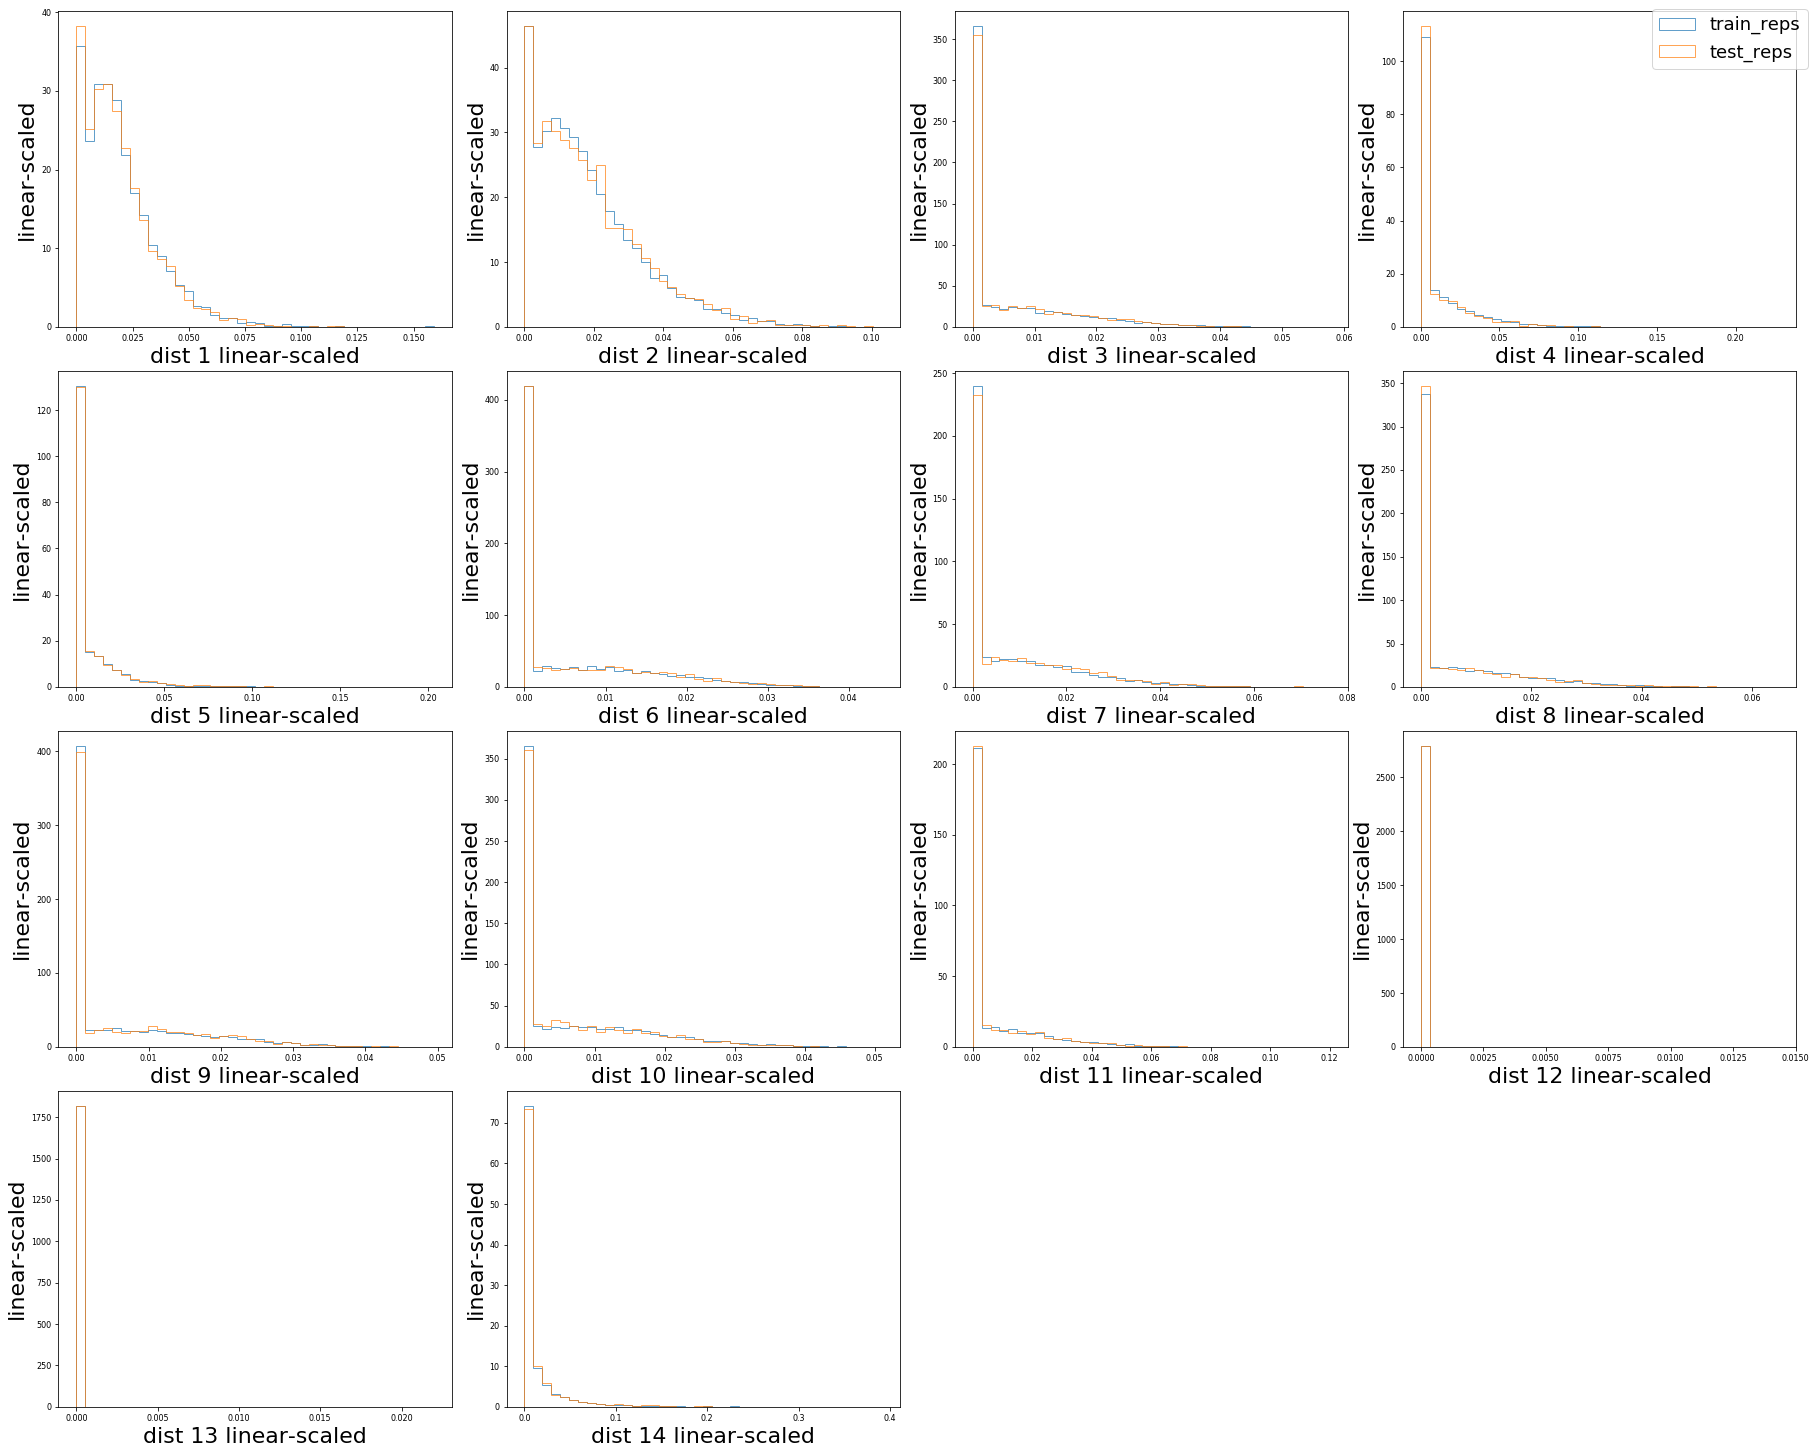

In [632]:
train_reps.plot([test_reps], cols=4, figsize=(25,20), fontsize=22, normed=1, bins=40)

In [633]:
errors = utils.data_table(np.asarray(map(
        lambda x: keras.backend.eval(getattr(keras.losses, x)(data.norm(**norm_args).data, data_recon_norm.data)),
        ["mse", "mae"]
    )).T,                      
    headers=["mse", "mae"],
    name="errors"
)

data_table :: plotting distrubution(s) for table(s) ['errors']


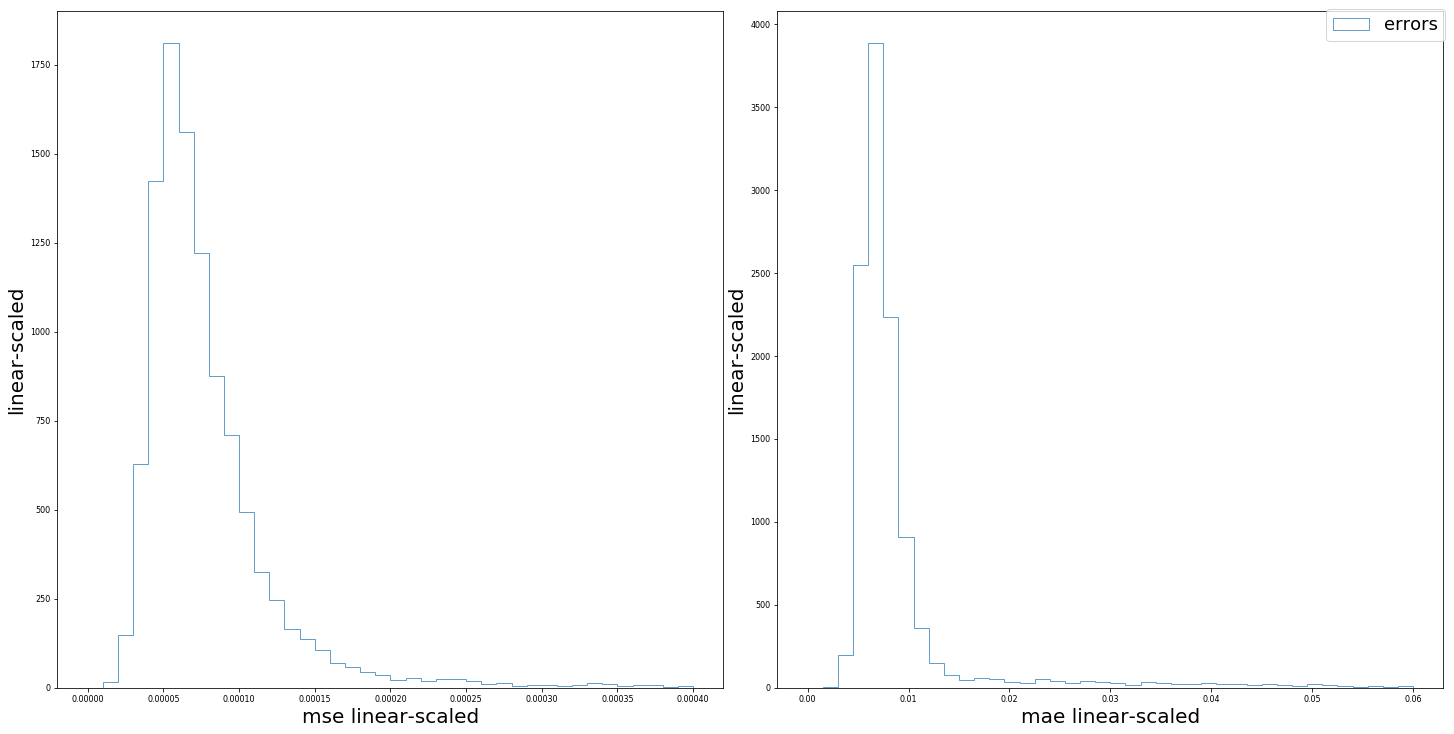

In [643]:
errors.plot(figsize=(20,10), bins=40, rng=((0,0.0004), (0, 0.06)), fontsize=20)

In [646]:
outlier_fraction = 0.01
index = np.argsort(errors.mae)
out_index = index[-int(outlier_fraction*len(errors)):]
reg_index = index[:-int(outlier_fraction*len(errors))]
print out_index.size + reg_index.size,len(errors)
print out_index.size, reg_index.size

11236 11236
112 11124


data_table :: plotting distrubution(s) for table(s) ['normal', 'outliers (top 0.01)']


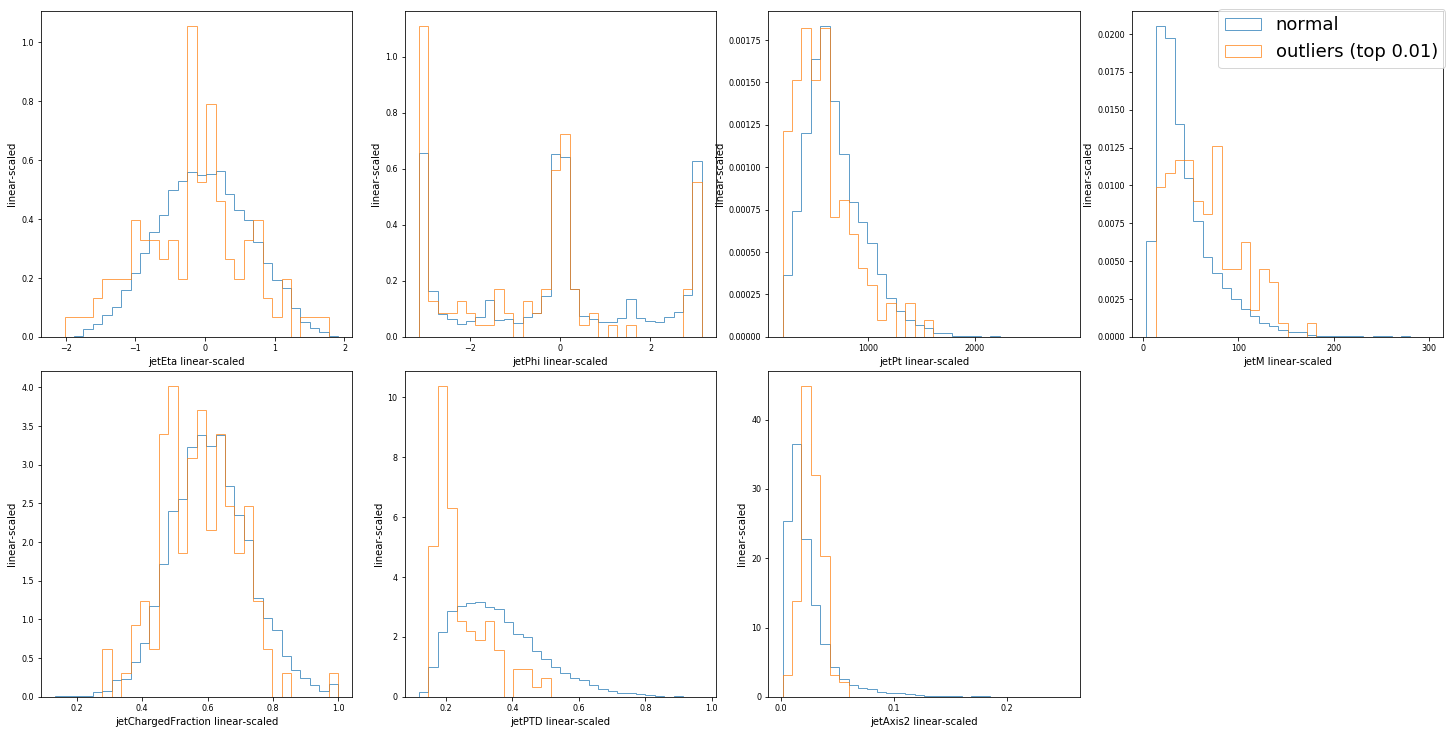

In [647]:
out,reg = (
    utils.data_table(data.data[out_index], headers=data.headers, name="outliers (top {})".format(outlier_fraction)), 
    utils.data_table(data.data[reg_index], headers=data.headers, name="normal")
)
reg.plot(out, normed=1, bins=30, figsize=(20,10))